n body ttv simulation demo

In this part, we simulate a two-planet star system and explore how the planets interact with each other to produce the effect of Transit Timing Variations (TTVs). The simulation uses simple gravitational interactions between three bodies: the star, planet 1, and planet 2. Specifically, we observe the transit of planet 1, with its timing variations caused by the gravitational influence of planet 2. This code models the motion of the planets and demonstrates how planet-planet interactions lead to variations in transit times.

Leap-Frog:

To implement this N-body simulation, we use the leapfrog method – a simple technique with good second-order accuracy and energy conservation. This method is similar to a basic (lazy) approach for calculating two-body gravitational interactions: at each time step, we calculate the force exerted based on the distance between two bodies, update the positions using the previous velocity, and then update the velocity based on the acceleration derived from the force.

However, this straightforward approach is unsuitable for modeling planetary systems because it does not conserve energy and leads to cumulative errors and numerical instabilities over time. One improvement involves averaging positions and accelerations across two time steps to update the system, but an even better method is to reorder the computation steps.

In the leapfrog method, positions are updated at full time steps, while velocities are updated at half time steps. This reordering means we update positions using velocities evaluated at the midpoint of the time step, while forces are computed based on the next position. This achieves second-order accuracy and better conserves energy.


Kepler to Cartesian:

Exoplanet transits can only be observed when the planet’s inclination is close to 90 degrees. In exoplanetary science, inclination refers to the angle between the orbital plane of the planet and the plane of the sky as seen from Earth. Many planets in evolved systems, such as those in the TRAPPIST-1 system, have stabilized inclinations around this value. Consequently, in our simulation, we simplify the problem by considering motion in a single plane, which we project onto the XY Cartesian plane. 

In orbital dynamics, it is common to describe orbits using Keplerian parameters, which include:
- Eccentricity (e): Describes the shape of the orbit.
- Semi-major axis (a): The orbit’s size.
- Inclination (i): The tilt of the orbital plane.
- Longitude of the Ascending Node (Ω): The orientation of the orbital plane in 3D space.
- Argument of Periapsis (ω): The orientation of the ellipse within the orbital plane.
- True Anomaly (ν): The position of the object along the orbit at a given time.

Defining initial coordinates and velocities in Cartesian form can be unintuitive for astronomers. We first convert the desired Keplerian parameters at t=0 into Cartesian coordinates and velocities.

Given the coplanar nature of our simulation, we make the following simplifications:
- Inclination (i) and Longitude of the Ascending Node (Ω) are irrelevant since there is only a single rotational axis for the orbital plane.
- The Argument of Periapsis (ω) defines the orientation of the orbital plane.
- We assume the objects start at periapsis, setting the True Anomaly (ν) to zero

Simulation Units and Input Parameters:
- Distance: Astronomical Units (AU).
- Time: Days (also for orbital periods).
- Planet Masses: Jupiter masses (Mjup)
- Star Mass: Solar masses (Msun)
- Gravitational Constant (G): AU^3 Mjup^-1 day^-2
- Eccentricity e: 0<=e<1
- Argument of Periapsis (ω): 
- w(argument os periapsis): 0<=w<=2pi
- Ntransits(int) - number of consecutively observed transits. A more realistic scenario for space-based observations.

Numba:

Our simulation involves a large loop with extensive calculations. To optimize performance, we use the Numba just-in-time compiler, which significantly speeds up the code by precompiling key functions.

First, we will demonstrate the core functions of the simulation and verify that energy is conserved. Then, we will compare computation times between the standard implementation and the Numba-optimized version.


In [5]:
import time
import numpy as np
from matplotlib import pyplot as plt
import numba as nb

G_SI = 6.67430e-11  # G in m^3 kg^-1 s^-2
AU = 1.496e11  # 1 AU in meters
Mjup = 1.898e27  # Mj in kilograms
day = 24 * 3600  # 1 day in seconds
G = G_SI / (AU**3 / (Mjup * (day)**2))

We will write a function to compute total energy of the system 


In [8]:
def compute_total_energy(x0, y0, vx0, vy0, m0,
                         x1, y1, vx1, vy1, m1,
                         x2, y2, vx2, vy2, m2, G):
    
    KE = (0.5 * m0 * (vx0**2 + vy0**2) +
          0.5 * m1 * (vx1**2 + vy1**2) +
          0.5 * m2 * (vx2**2 + vy2**2))

    r01 = np.sqrt((x0 - x1)**2 + (y0 - y1)**2)
    r02 = np.sqrt((x0 - x2)**2 + (y0 - y2)**2)
    r12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    PE = (-G * m0 * m1 / r01 - G * m0 * m2 / r02 - G * m1 * m2 / r12)
    
    return KE + PE


Convert meaningful Keplerian parameters at t=0 to initial positions and velocities. Except we will use periods instead of semi-major axis for the input.



In [11]:
def kepler_to_cartesian(T, e, omega, G, M_central):

    true_anomaly = 0

    a = (G * M_central * (T / (2 * np.pi))**2)**(1 / 3)

    r = a * (1 - e**2) / (1 + e * np.cos(true_anomaly))
    v = np.sqrt(G * M_central * (2 / r - 1 / a))

    x_orbit = r * np.cos(true_anomaly)
    y_orbit = r * np.sin(true_anomaly)

    vx_orbit = -v * np.sin(true_anomaly)
    vy_orbit = v * (e + np.cos(true_anomaly)) / (1 + e * np.cos(true_anomaly))

    cos_omega = np.cos(omega)
    sin_omega = np.sin(omega)
    x = cos_omega * x_orbit - sin_omega * y_orbit
    y = sin_omega * x_orbit + cos_omega * y_orbit
    vx = cos_omega * vx_orbit - sin_omega * vy_orbit
    vy = sin_omega * vx_orbit + cos_omega * vy_orbit

    return x, y, vx, vy

Now we define our leap-frog N-body simulation

In [14]:
def twoPlanetTTV(m0=1000, m1=1, m2=1,
                 T1=10, T2=100, e1=0, e2=0, w1=0, w2=0, Ntransits=10, savepos=False):

    m0 = m0*1047
    x0, y0, vx0, vy0 = 0, 0, 0, 0

    x1, y1, vx1, vy1 = kepler_to_cartesian(T1, e1, w1, G, m0)
    x2, y2, vx2, vy2 = kepler_to_cartesian(T2, e2, w2, G, m0)

    dt = 0.001  # Time step in days
    tmax = T1*Ntransits  # Total simulation time in days

    times = np.arange(0, tmax, dt)
    
    num_steps = len(times) + 1
    xs = np.zeros(num_steps)
    xs[0] = x1
    ts = np.zeros(Ntransits)  # Time of transits
    trans = 0

    if savepos:

        positions_0 = np.zeros((num_steps, 2))  # Particle 0 (x, y)
        positions_1 = np.zeros((num_steps, 2))  # Particle 1 (x, y)
        positions_2 = np.zeros((num_steps, 2))  # Particle 2 (x, y)

        positions_0[0] = [x0, y0]
        positions_1[0] = [x1, y1]
        positions_2[0] = [x2, y2]

    energies = np.zeros(num_steps-1)

    for i, t in enumerate(times):
        # Particle 0 and Particle 1
        dx01 = x0 - x1
        dy01 = y0 - y1
        r01_square = dx01**2 + dy01**2
        r01 = np.sqrt(r01_square)
        r01_cubed = r01 * r01_square

        # Particle 0 and Particle 2
        dx02 = x0 - x2
        dy02 = y0 - y2
        r02_square = dx02**2 + dy02**2
        r02 = np.sqrt(r02_square)
        r02_cubed = r02 * r02_square

        # Particle 1 and Particle 2
        dx12 = x1 - x2
        dy12 = y1 - y2
        r12_square = dx12**2 + dy12**2
        r12 = np.sqrt(r12_square)
        r12_cubed = r12 * r12_square

        # Forces on Particle 0
        fx0 = G * m1 * m0 * dx01 / r01_cubed + G * m2 * m0 * dx02 / r02_cubed
        fy0 = G * m1 * m0 * dy01 / r01_cubed + G * m2 * m0 * dy02 / r02_cubed

        # Forces on Particle 1
        fx1 = -G * m0 * m1 * dx01 / r01_cubed + G * m2 * m1 * dx12 / r12_cubed
        fy1 = -G * m0 * m1 * dy01 / r01_cubed + G * m2 * m1 * dy12 / r12_cubed

        # Forces on Particle 2
        fx2 = -G * m0 * m2 * dx02 / r02_cubed - G * m1 * m2 * dx12 / r12_cubed
        fy2 = -G * m0 * m2 * dy02 / r02_cubed - G * m1 * m2 * dy12 / r12_cubed

        # velocities
        vx0 += -dt * fx0 / m0
        vy0 += -dt * fy0 / m0
        vx1 += -dt * fx1 / m1
        vy1 += -dt * fy1 / m1
        vx2 += -dt * fx2 / m2
        vy2 += -dt * fy2 / m2

        # positions
        x0 += dt * vx0
        y0 += dt * vy0
        x1 += dt * vx1
        y1 += dt * vy1
        x2 += dt * vx2
        y2 += dt * vy2

        # x0 = 0
        # y0 = 0

        xs[i + 1] = x1

        if savepos:
            positions_0[i + 1] = [x0, y0]
            positions_1[i + 1] = [x1, y1]
            positions_2[i + 1] = [x2, y2]


        # Detect transits
        if y1 < 0 and xs[i] < 0 and xs[i + 1] > 0:
            ts[trans] = (times[i-1] + times[i]) / 2
            trans += 1

        E_total = compute_total_energy(x0, y0, vx0, vy0, m0,
                                        x1, y1, vx1, vy1, m1,
                                        x2, y2, vx2, vy2, m2, G)
        energies[i] = E_total

    if savepos:
        # np.save("positions_0.npy", positions_0)
        # np.save("positions_1.npy", positions_1)
        # np.save("positions_2.npy", positions_2)

        return ts, positions_0, positions_1, positions_2, energies

    else:

        return ts

let's test it out!

Execution time: 2.236465 seconds


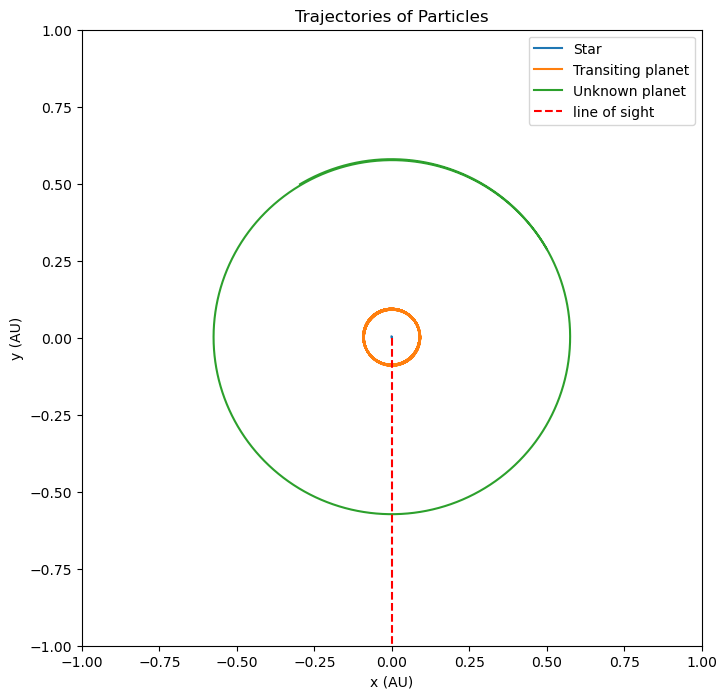

In [17]:
start_time = time.time()
ts, positions_0, positions_1, positions_2, energies = twoPlanetTTV(m0=1, m1=0.01, m2=1,
                  T1=10, T2=160, e1=0, e2=0.0, w1=0, w2=np.pi/6, Ntransits=20, savepos=True)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")


plt.figure(figsize=(8, 8))
plt.plot(positions_0[:, 0], positions_0[:, 1], label="Star")
plt.plot(positions_1[:, 0], positions_1[:, 1], label="Transiting planet")
plt.plot(positions_2[:, 0], positions_2[:, 1], label="Unknown planet")
plt.vlines(0, 0, -1, linestyle='--', color='r', label='line of sight')
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.legend()
plt.title("Trajectories of Particles")
plt.show()

We can clearly see our inner planet wobble! Let's quantify that by plotting the OC curve (Observed - Calculated time of the transit). In our simulation function, we assume the transit center time is when the planet's coordinates cross X axis while Y is negative. The error of such estimation lies in our time step size / 2, so 43 seconds.


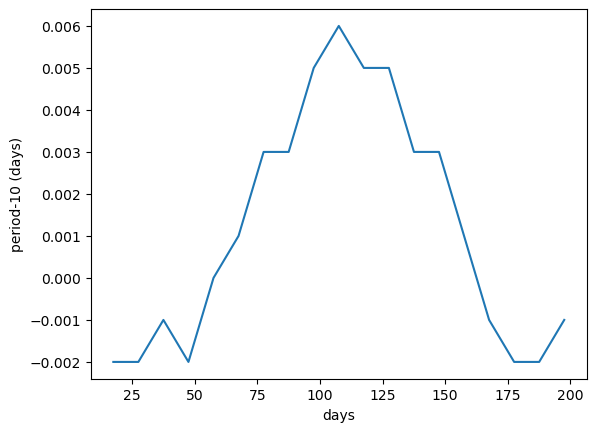

In [19]:
periods = np.diff(ts)

plt.plot(ts[1:], periods-10)
plt.ylabel('period-10 (days)')
plt.xlabel('days')
plt.show()


We can see that the transit occurs not strictly every 10 days like we initialized! 



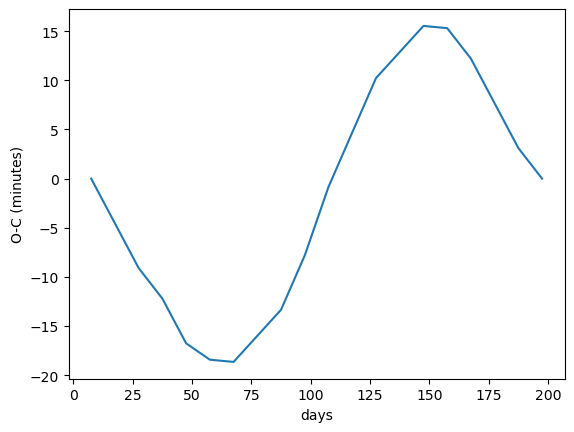

In [21]:
expected = [ts[0] + np.mean(periods) * n for n in range(len(ts))]

OC = ts - expected

plt.plot(ts, OC*24*60)
plt.xlabel("days")
plt.ylabel("O-C (minutes)")
plt.show()

np.savetxt('observed_OC(mins).txt', OC*24*60)

Let's see if the energy was conserved:

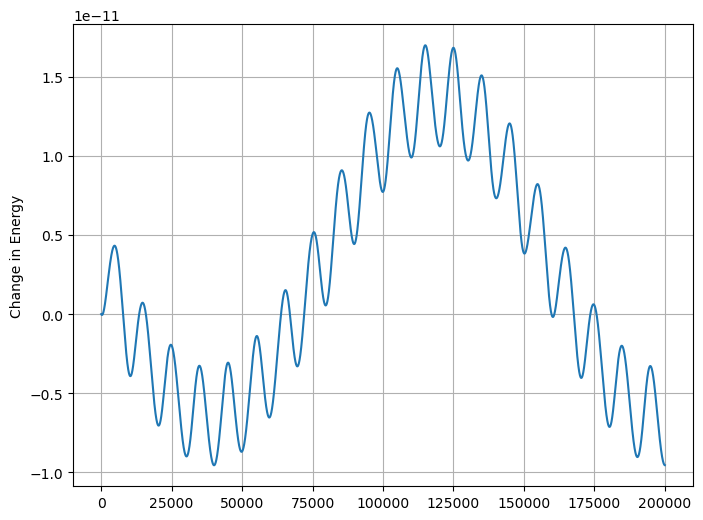

In [26]:

plt.figure(figsize=(8, 6))
plt.plot(energies - energies[0])
plt.ylabel("Change in Energy")
plt.grid()
plt.show()


The change is ~0, we can proudly say that we conserved energy!

Let's now run the function again with 50 transits and compare the speed with the Numba precompiled version



In [35]:
start_time = time.time()
ts = twoPlanetTTV(m0=1, m1=0.01, m2=1,
                  T1=10, T2=160, e1=0, e2=0.0, w1=0, w2=np.pi/6, Ntransits=50, savepos=False)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")


Execution time: 5.257771 seconds


In [37]:
@nb.njit(parallel=False)
def kepler_to_cartesian(T, e, omega, G, M_central):

    true_anomaly = 0

    a = (G * M_central * (T / (2 * np.pi))**2)**(1 / 3)

    r = a * (1 - e**2) / (1 + e * np.cos(true_anomaly))
    v = np.sqrt(G * M_central * (2 / r - 1 / a))

    x_orbit = r * np.cos(true_anomaly)
    y_orbit = r * np.sin(true_anomaly)

    vx_orbit = -v * np.sin(true_anomaly)
    vy_orbit = v * (e + np.cos(true_anomaly)) / (1 + e * np.cos(true_anomaly))

    cos_omega = np.cos(omega)
    sin_omega = np.sin(omega)
    x = cos_omega * x_orbit - sin_omega * y_orbit
    y = sin_omega * x_orbit + cos_omega * y_orbit
    vx = cos_omega * vx_orbit - sin_omega * vy_orbit
    vy = sin_omega * vx_orbit + cos_omega * vy_orbit

    return x, y, vx, vy

@nb.njit(parallel=False)
def twoPlanetTTV(m0=1000, m1=1, m2=1,
                 T1=10, T2=100, e1=0, e2=0, w1=0, w2=0, Ntransits=10):

    m0 = m0*1047
    x0, y0, vx0, vy0 = 0, 0, 0, 0

    x1, y1, vx1, vy1 = kepler_to_cartesian(T1, e1, w1, G, m0)
    x2, y2, vx2, vy2 = kepler_to_cartesian(T2, e2, w2, G, m0)

    dt = 0.001  # Time step in days
    tmax = T1*Ntransits  # Total simulation time in days

    times = np.arange(0, tmax, dt)
    
    num_steps = len(times) + 1
    xs = np.zeros(num_steps)
    xs[0] = x1
    ts = np.zeros(Ntransits)  # Time of transits
    trans = 0

    for i, t in enumerate(times):
        # Particle 0 and Particle 1
        dx01 = x0 - x1
        dy01 = y0 - y1
        r01_square = dx01**2 + dy01**2
        r01 = np.sqrt(r01_square)
        r01_cubed = r01 * r01_square

        # Particle 0 and Particle 2
        dx02 = x0 - x2
        dy02 = y0 - y2
        r02_square = dx02**2 + dy02**2
        r02 = np.sqrt(r02_square)
        r02_cubed = r02 * r02_square

        # Particle 1 and Particle 2
        dx12 = x1 - x2
        dy12 = y1 - y2
        r12_square = dx12**2 + dy12**2
        r12 = np.sqrt(r12_square)
        r12_cubed = r12 * r12_square

        # Forces on Particle 0
        fx0 = G * m1 * m0 * dx01 / r01_cubed + G * m2 * m0 * dx02 / r02_cubed
        fy0 = G * m1 * m0 * dy01 / r01_cubed + G * m2 * m0 * dy02 / r02_cubed

        # Forces on Particle 1
        fx1 = -G * m0 * m1 * dx01 / r01_cubed + G * m2 * m1 * dx12 / r12_cubed
        fy1 = -G * m0 * m1 * dy01 / r01_cubed + G * m2 * m1 * dy12 / r12_cubed

        # Forces on Particle 2
        fx2 = -G * m0 * m2 * dx02 / r02_cubed - G * m1 * m2 * dx12 / r12_cubed
        fy2 = -G * m0 * m2 * dy02 / r02_cubed - G * m1 * m2 * dy12 / r12_cubed

        # velocities
        vx0 += -dt * fx0 / m0
        vy0 += -dt * fy0 / m0
        vx1 += -dt * fx1 / m1
        vy1 += -dt * fy1 / m1
        vx2 += -dt * fx2 / m2
        vy2 += -dt * fy2 / m2

        # positions
        x0 += dt * vx0
        y0 += dt * vy0
        x1 += dt * vx1
        y1 += dt * vy1
        x2 += dt * vx2
        y2 += dt * vy2

        # x0 = 0
        # y0 = 0

        xs[i + 1] = x1

        # Detect transits
        if y1 < 0 and xs[i] < 0 and xs[i + 1] > 0:
            ts[trans] = (times[i-1] + times[i]) / 2
            trans += 1

    return ts

In [39]:
start_time = time.time()
ts = twoPlanetTTV(m0=1, m1=0.01, m2=1,
                  T1=10, T2=160, e1=0, e2=0.0, w1=0, w2=np.pi/6, Ntransits=50)
end_time = time.time()
print(f"Execution time wiht numba: {end_time - start_time:.6f} seconds")

Execution time wiht numba: 1.779085 seconds


This is a big difference! We didn't parallelize because our calculations rely on previous values.

This function can be used as a demonstration and as a model for sampling with MCMC. Introducing further improvements like 3-D orbits won't be a challenge. Adding more planets will add more lines of code if we do it the lazy way with the leap frog.

